# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

In [1]:
project_root = dirname(dirname(@__DIR__))
using Pkg
Pkg.activate(project_root)     
Pkg.instantiate()     

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [2]:
using RCall
simulation_name = "5_predictors"
simulation_settings_file = "setting"
user_libs = "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"

simulation_file_path = joinpath(project_root, "simulations", "settings",simulation_name, simulation_settings_file * ".R")
runner_file_path = joinpath(project_root, "simulations", "run.R")

# Optionally, define overrides here and pass them to R
overrides = Dict()

@rput simulation_file_path
@rput runner_file_path
@rput user_libs
@rput overrides

R"""
.libPaths(c(user_libs, .libPaths()))
source(simulation_file_path)
# Apply overrides if provided
if (exists('overrides')) {
    for (param_name in names(overrides)) {
      params[[param_name]] <- overrides[[param_name]]
    }
}

source(runner_file_path)
"""



base64 binary data: G1szM20bWzFt4pSMIBtbMjJtG1szOW0bWzMzbRtbMW1XYXJuaW5nOiAbWzIybRtbMzltUkNhbGwuamw6IENhcmljYW1lbnRvIGRlbCBwYWNjaGV0dG8gcmljaGllc3RvOiBzcGxpbmVzChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IGZkcwobWzMzbRtbMW3ilIIgG1syMm0bWzM5bUNhcmljYW1lbnRvIGRlbCBwYWNjaGV0dG8gcmljaGllc3RvOiByYWluYm93ChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IHBjYVBQChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IFJDdXJsChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IGRlU29sdmUKG1szM20bWzFt4pSCIBtbMjJtG1szOW0KG1szM20bWzFt4pSCIBtbMjJtG1szOW1DYXJpY2FtZW50byBwYWNjaGV0dG86ICdmZGEnChtbMzNtG1sxbeKUgiAbWzIybRtbMzltChtbMzNtG1sxbeKUgiAbWzIybRtbMzltSWwgc2VndWVudGUgb2dnZXR0byDoIG1hc2NoZXJhdG8gZGEgJ3BhY2thZ2U6Z3JhcGhpY3MnOgobWzMzbRtbMW3ilIIgG1syMm0bWzM5bQobWzMzbRtbMW3ilIIgG1syMm0bWzM5bSAgICBtYXRwbG90ChtbMzNtG1sxbeKUgiAbWzIybRtbMzltChtbMzNtG1sxbeKUgiAbWzIybRtbMzltaGVyZSgpIHN0YXJ0

RObject{VecSxp}
$value
$value$X
, , 1

               [,1]          [,2]     [,3]     [,4]      [,5]
  [1,] -0.521447312  0.3878044403 4.880084 3.017262 2.1900244
  [2,] -0.424444220  1.2374336234 4.220151 1.942533 2.1938988
  [3,]  0.458563554  0.3487559855 4.398287 2.085770 2.4231637
  [4,] -0.125525902  1.3184742266 3.753329 2.303321 2.6832618
  [5,] -0.619891986  0.4980881911 4.915185 3.162497 1.7327210
  [6,]  0.393742236  0.0992598351 4.957792 3.785224 2.1322337
  [7,]  0.342136136  0.4808667317 3.907109 2.788831 1.5205095
  [8,]  0.476195423  1.3757523257 3.991285 3.464385 1.9343534
  [9,]  0.185194146  0.4921040734 4.397648 1.686951 1.1026051
 [10,]  0.305412011  0.8205439063 3.672623 1.989036 2.2513482
 [11,] -0.167542104  0.5033267127 3.772518 2.050635 2.8697098
 [12,]  0.052850141 -0.0534349165 2.907534 2.429696 2.2591142
 [13,] -0.149048510  1.2232973238 3.940243 2.425198 2.3641821
 [14,]  0.251641527  0.4798007555 4.062790 2.298653 1.5409153
 [15,]  0.716237488  1.20401229

## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

In [3]:

# grab the outputs from the R script

# Sample input data
predictors = rcopy(R"(params$predictors)")
true_predictors = rcopy(R"(outputs$true_predictors)")
intercept = rcopy(R"(params$intercept)")
observations = rcopy(R"(params$observations)")


# betas and basis
beta_matrix = rcopy(R"(outputs$B)")
basis_objs = rcopy(R"(outputs$basis_objs)")
basis_values = rcopy(R"(outputs$basis_values)")
time_domains    = rcopy(R"(params$time_domains)")

# matrixes 
X = rcopy(R"(outputs$X)")
Y = rcopy(R"(outputs$Y)")
Z = rcopy(R"(outputs$Z)")
J = rcopy(R"(outputs$J)")
W = rcopy(R"(outputs$W)");


In [4]:
using Plots
# REAL Y

obs = 1
predictor = 1
plot(X[obs,predictor,:])



# APPROX Y
display(plot!())

coeff = W[obs, predictor, :]

# matrix multiplication of basis_values and coefficients
mat = basis_values[predictor,:,:] * coeff
# curve_values = basis_values * coefs
plot(mat)
display(plot!())
print(coeff)


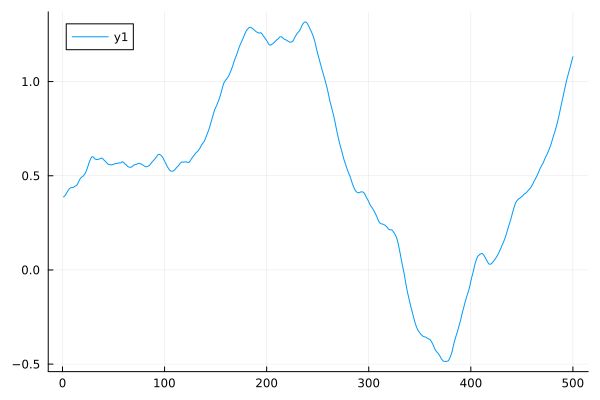

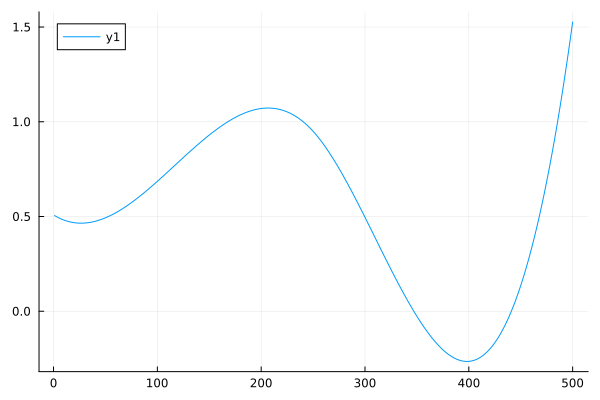

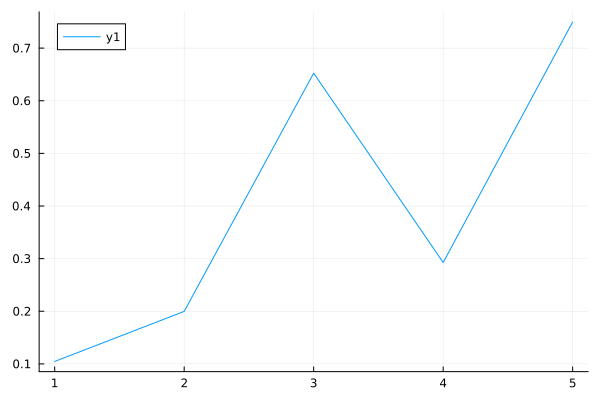

In [ ]:

predictor = 2
obs = 1
# plot the predictor in the first 20 observations
plot(X[1, predictor, :])
for i in 2:obs
    plot!(X[i, predictor, :])
end
display(plot!())


# # plot W using the corresponding basis objective

# plot the predictor in the first 20 observations

plot(basis_values[predictor,:,:] * W[1, predictor, :])
for i in 2:obs
    plot!(basis_values[predictor,:,:] *W[i, predictor, :] )
end
display(plot!())

# plot W using the corresponding basis objective

# plot the predictor in the first 20 observations

plot(Z[1, predictor, :])
for i in 2:obs
    plot!(Z[i, predictor, :])
end
display(plot!())

In [ ]:
J

5×5×5 Array{Float64, 3}:
[:, :, 1] =
 0.0714286  0.0437502  0.00892797  0.000893073  0.0
 0.0747998  0.0458151  0.00934934  0.000935224  0.0
 0.142857   0.0875004  0.0178559   0.00178615   0.0
 0.0747998  0.0458151  0.00934934  0.000935224  0.0
 0.214286   0.131251   0.0267839   0.00267922   0.0

[:, :, 2] =
 0.0437502  0.110713  0.0696445  0.0249991  0.000893073
 0.0458151  0.115939  0.0729315  0.026179   0.000935224
 0.0875004  0.221427  0.139289   0.0499983  0.00178615
 0.0458151  0.115939  0.0729315  0.026179   0.000935224
 0.131251   0.33214   0.208933   0.0749974  0.00267922

[:, :, 3] =
 0.00892797  0.0696445  0.0928547  0.0696445  0.00892797
 0.00934934  0.0729315  0.0972372  0.0729315  0.00934934
 0.0178559   0.139289   0.185709   0.139289   0.0178559
 0.00934934  0.0729315  0.0972372  0.0729315  0.00934934
 0.0267839   0.208933   0.278564   0.208933   0.0267839

[:, :, 4] =
 0.000893073  0.0249991  0.0696445  0.110713  0.0437502
 0.000935224  0.026179   0.0729315  0.115939  0

In [ ]:
W[1,1,:]

5-element Vector{Float64}:
 -0.613958199952249
  1.405453169548811
  0.41318388061258005
 -2.1042536045290214
 -0.2957745596232302

In [ ]:
Z[1,1,:]

5-element Vector{Float64}:
 0.019444361871731413
 0.07180885369207118
 0.7658172962786062
 0.3010419506176077
 0.6595757948060381

In [ ]:
Y

500-element Vector{Float64}:
 8.566296200171099
 8.590663570255941
 7.415184068406662
 7.218499164785344
 6.651629282387168
 8.778211705434622
 7.246947244535793
 8.37390430866631
 7.169090819634041
 7.368166532944791
 8.434721650038961
 7.5261852387463835
 7.316243296603601
 ⋮
 7.507810762263227
 8.928427301080015
 8.141811813966108
 9.568704614416722
 8.429665811910104
 5.34644117914661
 6.646083643710638
 6.693657873514525
 7.739753155358515
 9.687745999462761
 9.269463776945424
 8.31785530356267

## Plotting Inputs
Visualize the input data to understand its distribution and structure before running the model.

In [ ]:

# R"""
# source(here("src", "R", "data_simulator","utils", "plot_utilities.R"))

# plot_design_matrix(     J, "J", "basis","basis")
# # #loop over the rows of Z in R code
# for( i in 1:2 ) {
#     plot_design_matrix(Z[i,,], paste("Z-obv",i),"basis", "predictor")
#     plot_design_matrix(W[i, ,], paste("W-obv",i),"basis", "predictor")
# }
# plot_design_matrix(basis_values[1,,], "Basis Values", "basis","times")

# """

## Model Execution
Run the predictive model using the prepared data.

In [ ]:
model_name = "l0_and_limit.jl"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name)

include(model_file_path)

λ =0.01
λ_group = 0.001
M = 1000

beta_star, alpha_star, groups = mip_functional_regression(Y, Z, λ, λ_group, M, sum(true_predictors))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 60
Set parameter Presolve to value 2
Set parameter Heuristics to value 0.5
Set parameter MIPGap to value 0.05
Set parameter Threads to value 1
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 0.01
Set parameter IntFeasTol to value 1e-06
Set parameter Threads to value 1
Set parameter TimeLimit to value 60
Set parameter NumericFocus to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter MIPGap to value 0.05
Set parameter OptimalityTol to value 0.01
Set parameter IntFeasTol to value 1e-06
Set parameter NonConvex to value 2
Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 log

([1.164711761232379 2.1779037886961254 … 3.618700471842532 3.902715575380777; -0.07093782713262053 0.3797498101535002 … 1.740120829868073 2.063817621253599; … ; 0.0 0.0 … 0.0 0.0; -3.8120220423402045 -2.609211577766559 … 1.2458053995655305 1.8554122942912212], 0.0, [1, 1, 0, 0, 1])

## Model Results
Display the results of the model, including the estimated beta coefficients.

In [ ]:
groups

5-element Vector{Int64}:
 1
 1
 0
 0
 1

In [ ]:
beta_matrix # true beta

5×5 Matrix{Float64}:
  1.47142     1.71732    2.32651   3.33453  3.99974
 -0.0090447   0.373785   0.993578  1.80411  2.00888
  0.0         0.0        0.0       0.0      0.0
  0.0         0.0        0.0       0.0      0.0
 -4.0        -3.0       -1.0       1.0      2.0

In [ ]:
beta_star  # estimated beta

5×5 Matrix{Float64}:
  1.16471     2.1779    2.18501   3.6187   3.90272
 -0.0709378   0.37975   1.05492   1.74012  2.06382
  0.0         0.0       0.0       0.0      0.0
  0.0         0.0       0.0       0.0      0.0
 -3.81202    -2.60921  -0.962251  1.24581  1.85541

## Data Comparison
Compare the true beta matrix with the estimated beta matrix and calculate errors.

In [ ]:
using DataFrames

# Ensure beta_matrix and beta_star have the same dimensions
if size(beta_matrix) != size(beta_star)
    error("beta_matrix and beta_star must have the same dimensions")
end

# Create a DataFrame and calculate the percentage error for each coefficient
df = DataFrame()
for i in 1:size(beta_matrix, 2)
    percent_error_col = Symbol("%_err_$i")

    # Replace values less than 10^-6 with zero in beta_matrix and beta_star
    beta_matrix[:, i] = ifelse.(abs.(beta_matrix[:, i]) .< 1e-6, 0, beta_matrix[:, i])
    beta_star[:, i] = ifelse.(abs.(beta_star[:, i]) .< 1e-6, 0, beta_star[:, i])

    # Calculate the percentage error while handling division by zero
    percent_error = ifelse.(beta_matrix[:, i] .== 0,
        ifelse.(beta_star[:, i] .== 0, 0, 100),
        round.(((beta_star[:, i] .- beta_matrix[:, i]) ./ beta_matrix[:, i]) .* 100, digits = 2)
    )

    # Convert the percentage error to a string with the percentage symbol
    df[!, percent_error_col] = string.(percent_error, " %")
end

# Show the DataFrame
display(df)

Row,%_err_1,%_err_2,%_err_3,%_err_4,%_err_5
,String,String,String,String,String
1,-20.84 %,26.82 %,-6.08 %,8.52 %,-2.43 %
2,684.3 %,1.6 %,6.17 %,-3.55 %,2.73 %
3,0 %,0 %,0 %,0 %,0 %
4,0 %,0 %,0 %,0 %,0 %
5,-4.7 %,-13.03 %,-3.77 %,24.58 %,-7.23 %


## Evaluate Model Performance
Evaluate the model's performance using various metrics such as MSE, RMSE, MAE, and relative error.

In [ ]:
using Statistics 
using LinearAlgebra

# Compute the difference between gamma_matrix and gamma_star
diff_matrix = beta_matrix - beta_star

# Evaluation Metrics
mse = sum((diff_matrix).^2) / length(beta_star)  # Mean Squared Error
rmse = sqrt(mse)                                  # Root Mean Squared Error
mae = sum(abs.(diff_matrix)) / length(beta_star)  # Mean Absolute Error
relative_error = norm(diff_matrix) / norm(beta_star)  # Relative Error

# Print or use the evaluation metrics as needed
println("Mean Squared Error (MSE): $mse")
println("Root Mean Squared Error (RMSE): $rmse")
println("Mean Absolute Error (MAE): $mae")
println("Relative Error: $relative_error")


Mean Squared Error (MSE): 0.028077642745789763
Root Mean Squared Error (RMSE): 0.1675638467742662
Mean Absolute Error (MAE): 0.10180054940331924
Relative Error: 0.09673675756880944


## Prediction and Evaluation
Make predictions using the estimated coefficients and evaluate the model's accuracy.


1. **Root Mean Square Error (RMSE)**:
   - RMSE provides a measure of the magnitude of the error. It's more sensitive to outliers than MSE because it gives a higher weight to larger errors.
   
2. **Mean Absolute Percentage Error (MAPE)**:
   - MAPE expresses the error as a percentage of the actual values, which can make it easier to interpret in terms of relative error.

3. **Median Absolute Deviation (MAD)**:
   - MAD is robust to outliers and provides a median-based measure of the deviations.

4. **Coefficient of Determination (\( R^2 \)) Adjusted**:
   - The adjusted \( R^2 \) compensates for the number of predictors in the model, providing a more accurate measure of the goodness of fit for models with a large number of variables.

5. **Normalized Root Mean Square Error (NRMSE)**:
   - NRMSE normalizes RMSE by the range of the data, which allows for comparison between datasets with different scales.

6. **Distance Metrics for Curve Comparison**:
   - **Euclidean Distance**: The straight-line distance between two points in Euclidean space can be extended to compare the shape of two curves.
   - **Dynamic Time Warping (DTW)**: A more sophisticated approach that aligns two sequences (curves) by stretching or compressing segments to measure similarity despite shifts or distortions.
   - **Frechet Distance**: Measures the similarity between curves by considering the location and ordering of the points along the curves.

7. **Area Between Two Curves (ABC)**:
   - This metric calculates the area between the predicted curve and the actual curve, which can be useful for understanding the overall difference over the range of data.

8. **Dice Coefficient/Sørensen Index**:
   - A statistic used to gauge the similarity of two samples. It could be adapted to compare the similarity between two curves, especially if they are binarized.

9. **Bhattacharyya Distance**:
   - A measure of the similarity of two probability distributions. It can be used to compare the distributions of errors between the predicted and actual values.


In [ ]:
using Statistics

# Function to obtain predictions using the estimated coefficients
function get_predictions(X_coeff, gamma_star, alpha_star)
    n, p, r = size(X_coeff)
    _, r_star = size(gamma_star) # get the actual size of gamma_star

    predictions = zeros(n)
    for i in 1:n
        prediction = 0
        for j in 1:p
            for k in 1:min(r, r_star)  # use the smaller of r and r_star
                prediction += X_coeff[i, j, k] * gamma_star[j, k]
            end
        end
        predictions[i] = prediction
    end

    return predictions
end




# Get predictions
Y_pred = get_predictions( Z, beta_star, alpha_star)





500-element Vector{Float64}:
 8.024677159431299
 8.746151865449304
 7.689329640406886
 7.784758554041036
 7.227932789107102
 8.685959178029268
 7.3364330692675335
 8.450597165196804
 7.194867808516316
 7.48859037868299
 8.329788371012658
 8.223137172285426
 7.239561624055609
 ⋮
 7.782109671958108
 8.220490224338775
 8.23640665500235
 9.182859833559103
 8.541347530416742
 5.355989695592209
 6.914732842198174
 7.1332660617162365
 7.660790251723666
 9.153580193593196
 9.153726031291217
 7.846344538703525

In [ ]:
using Statistics

# RMSE
function calculate_rmse(Y_true, Y_pred)
    n = length(Y_true)
    return sqrt(sum((Y_true[i] - Y_pred[i])^2 for i in 1:n) / n)
end

# MAE
function calculate_mae(Y_true, Y_pred)
    n = length(Y_true)
    mae = sum(abs(Y_true[i] - Y_pred[i]) for i in 1:n) / n
    return  mae
end

# MSE
function calculate_mse(Y_true, Y_pred)
    n = length(Y_true)
    mse = sum((Y_true[i] - Y_pred[i])^2 for i in 1:n) / n
    return  mse
end

# MAPE
function calculate_mape(Y_true, Y_pred)
    n = length(Y_true)
    return 100 * sum(abs((Y_true[i] - Y_pred[i]) / Y_true[i]) for i in 1:n if Y_true[i] != 0) / n
end

# MAD
function calculate_mad(Y_true, Y_pred)
    return median(abs.(Y_true - Y_pred))
end

# Adjusted R^2
function calculate_adjusted_r2(Y_true, Y_pred, p)
    n = length(Y_true)
    mse = sum((Y_true[i] - Y_pred[i])^2 for i in 1:n) / n
    var_y_true = var(Y_true)
    r2 = 1 - mse / var_y_true
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
end

# NRMSE
function calculate_nrmse(Y_true, Y_pred)
    rmse = calculate_rmse(Y_true, Y_pred)
    return rmse / (maximum(Y_true) - minimum(Y_true))
end

# ABC
function calculate_abc(Y_true, Y_pred)
    return sum(abs.(Y_true - Y_pred))
end


# Get predictions
Y_pred = get_predictions(Z, beta_star, alpha_star)



# Evaluate the model using new metrics
rmse = calculate_rmse(Y, Y_pred)
mape = calculate_mape(Y, Y_pred)
mae = calculate_mae(Y, Y_pred)
mse = calculate_mse(Y, Y_pred)
mad = calculate_mad(Y, Y_pred)
adjusted_r2 = calculate_adjusted_r2(Y, Y_pred, predictors)
nrmse = calculate_nrmse(Y, Y_pred)
abc = calculate_abc(Y, Y_pred)

# Valuation of metrics
println("MSE: $mse, MAE: $mae")
println("RMSE: $rmse (Lower is better. Below 0.1 is excellent, but depends on data scale.)")
println("MAPE: $mape% (Lower is better. Typically < 10% is good.)")
println("MAD: $mad (Lower is better. Less sensitive to outliers than RMSE.)")
println("Adjusted R2: $adjusted_r2 (Higher is better. Closer to 1 indicates a better fit.)")
println("NRMSE: $nrmse (Lower is better. Below 0.1 is excellent, but depends on data scale.)")
println("ABC: $abc (Lower is better. No standard threshold; context-dependent.)")


# Add a qualitative valuation
function valuate_metric(metric_value, good_threshold, excellent_threshold=nothing, higher_is_better=false)
    if isnothing(excellent_threshold)
        if higher_is_better
            return metric_value > good_threshold ? "Good" : "Poor"
        else
            return metric_value < good_threshold ? "Good" : "Poor"
        end
    else
        if higher_is_better
            if metric_value > excellent_threshold
                return "Excellent"
            elseif metric_value > good_threshold
                return "Good"
            else
                return "Poor"
            end
        else
            if metric_value < excellent_threshold
                return "Excellent"
            elseif metric_value < good_threshold
                return "Good"
            else
                return "Poor"
            end
        end
    end
end



MSE: 0.103265582113405, MAE: 0.2506463701643856
RMSE: 0.3213496259736504 (Lower is better. Below 0.1 is excellent, but depends on data scale.)
MAPE: 3.1797559613321416% (Lower is better. Typically < 10% is good.)
MAD: 0.20576004448246632 (Lower is better. Less sensitive to outliers than RMSE.)
Adjusted R2: 0.8927632802534681 (Higher is better. Closer to 1 indicates a better fit.)
NRMSE: 0.04723249433183722 (Lower is better. Below 0.1 is excellent, but depends on data scale.)
ABC: 125.3231850821928 (Lower is better. No standard threshold; context-dependent.)


valuate_metric (generic function with 3 methods)

In [ ]:


# Valuation of metrics
metrics = Dict(
    "MSE" => mse,
    "MAE" => mae,
    "RMSE" => rmse,
    "MAPE" => mape,
    "MAD" => mad,
    "Adjusted R2" => adjusted_r2,
    "NRMSE" => nrmse,
    "ABC" => abc
)

thresholds = Dict(
    "MSE" => (0.2, 0.1),
    "MAE" => (0.2, 0.1),
    "RMSE" => (0.2, 0.1),
    "MAPE" => (10, 5),
    "MAD" => (0.2, 0.1),
    "Adjusted R2" => (0.8, 0.9),
    "NRMSE" => (0.2, 0.1),
    "ABC" => (0.2, 0.1)
)

higher_is_better = Dict(
    "MSE" => false,
    "MAE" => false,
    "RMSE" => false,
    "MAPE" => false,
    "MAD" => false,
    "Adjusted R2" => true,
    "NRMSE" => false,
    "ABC" => false
)

for (metric, value) in metrics
    good_threshold, excellent_threshold = thresholds[metric]
    is_higher_better = higher_is_better[metric]
    valuation = valuate_metric(value, good_threshold, excellent_threshold, is_higher_better)
    println("$metric: $value, Valuation: $valuation")
end

ABC: 125.3231850821928, Valuation: Poor
MAPE: 3.1797559613321416, Valuation: Excellent
RMSE: 0.3213496259736504, Valuation: Poor
MAE: 0.2506463701643856, Valuation: Poor
MAD: 0.20576004448246632, Valuation: Poor
NRMSE: 0.04723249433183722, Valuation: Excellent
MSE: 0.103265582113405, Valuation: Good
Adjusted R2: 0.8927632802534681, Valuation: Good


# Robust Statistics and Outliers

Robust statistics are statistical methods that provide good performance even when the data contains outliers or when the data model assumptions are not entirely met. 

Traditional statistical methods can be significantly affected by a single or few outliers. For example, the mean of a dataset is highly sensitive to outliers. A single extreme value can drastically change the mean, which can lead to misleading results.

On the other hand, robust statistical methods, such as the median or interquartile range, are not as affected by outliers. These methods provide a more accurate representation of the data, especially when dealing with real-world data that often contains outliers.

Therefore, using robust statistics is often a better choice when handling datasets with outliers.

To address this, we can incorporate robust statistical methods that are less sensitive to outliers or modify existing metrics to take the full curve into account when evaluating the performance. One such approach is to use the interquartile range (IQR) to identify outliers in the space of coefficients.

In [ ]:
using Statistics

# Function to calculate the robust distance between coefficient curves using IQR
function calculate_robust_curve_distance_IQR(beta_matrix, beta_star, groups)
    distance = 0.0
    # Loop over each predictor
    for j in 1:size(beta_matrix, 1)
        if groups[j] == 1  # Only if the predictor is selected
            predictor_coeffs = beta_matrix[j, :]
            # Calculate the interquartile range (IQR)
            q1 = quantile(predictor_coeffs, 0.25)
            q3 = quantile(predictor_coeffs, 0.75)
            iqr = q3 - q1

            # Define the non-outlier range
            non_outlier_min = q1 - 1.5 * iqr
            non_outlier_max = q3 + 1.5 * iqr

            # Compute distance only for non-outlier coefficients
            for i in 1:size(beta_matrix, 2)
                coeff = predictor_coeffs[i]
                # Include the coefficient in the distance calculation if it's not an outlier
                if coeff >= non_outlier_min && coeff <= non_outlier_max
                    distance += (coeff - beta_star[j, i])^2
                end
            end
        end
    end
    return sqrt(distance)
end

# Example usage
robust_curve_distance = calculate_robust_curve_distance_IQR(beta_matrix, beta_star, groups)
println("Robust Curve Distance: $robust_curve_distance")


Robust Curve Distance: 0.837819233871331


## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

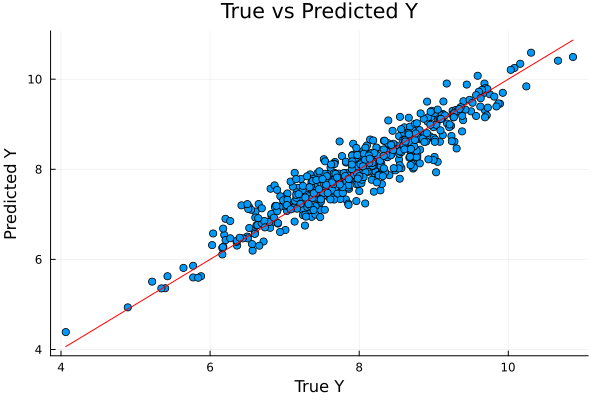

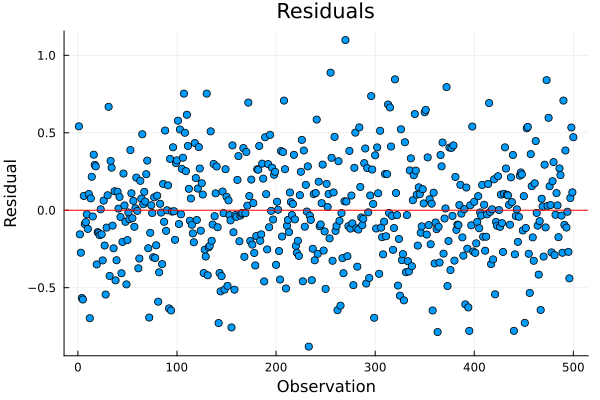

In [ ]:
using Plots


# 1. Scatter plot comparing true vs predicted values
scatter(Y, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y, Y, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y - Y_pred
scatter(1:observations, residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


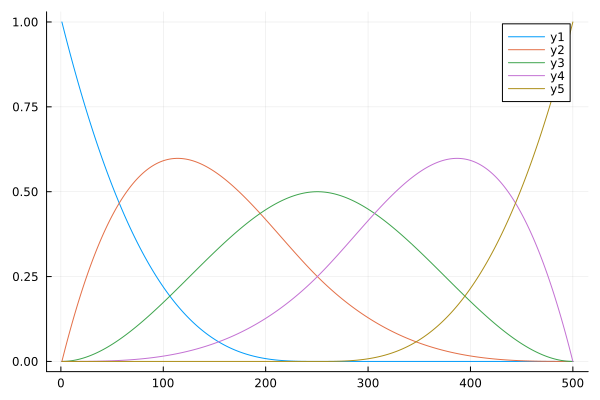

In [ ]:
pbasis_values =basis_values
plot( pbasis_values[1,:,1])
plot!(pbasis_values[1,:,2])
plot!(pbasis_values[1,:,3])
plot!(pbasis_values[1,:,4])
plot!(pbasis_values[1,:,5])


## Final Output
Plot the combined predicted curve and save the output for further analysis.

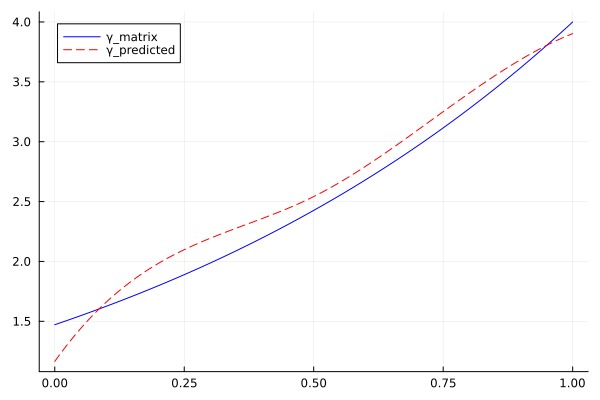

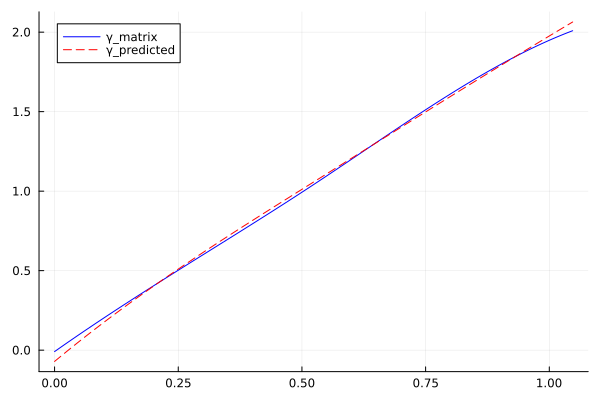

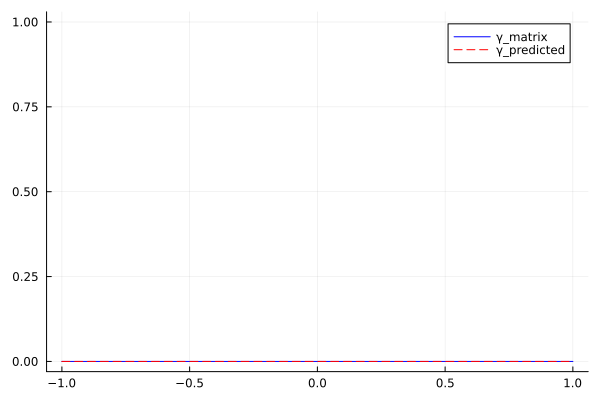

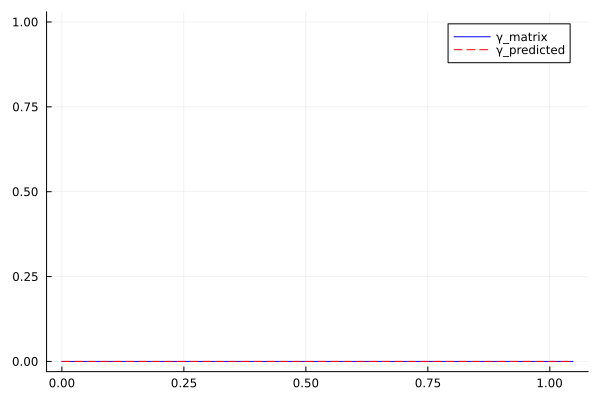

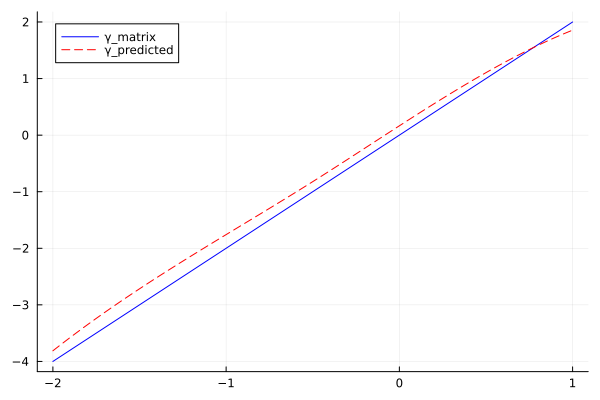

In [ ]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

plot_combined_predicted_curve_paper(beta_matrix, beta_star,basis_values, time_domains,output_folder, true)


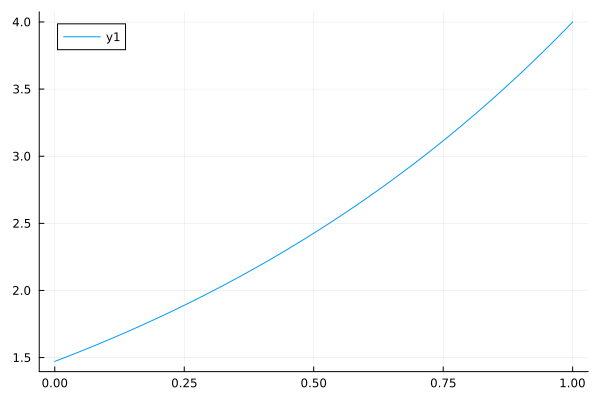

In [ ]:
y =basis_values[1,:,:] * beta_matrix[1,:];
function evenly_spaced(a, b, n)
    h = (b-a)/(n-1)
    collect(a:h:b)
end

x= evenly_spaced(0, 1, 500)

plot(x,y)